In [2]:
### Version checks
import numpy as np
import glob

from pyfaidx import Fasta
fasta_seq=Fasta('/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats
from pybedtools import BedTool

In [3]:
import re
df = pd.DataFrame()
df_auroc = pd.DataFrame()
outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/models_250_1364_minibatch_prejitter/"
cancer_to_auroc = {}
for cancer_name in ["GBM","BRCA","KIRC","KIRP","COAD","BLCA","LUAD","SKCM"]:
    print(cancer_name)
    avg_auroc= []
    avg_auprc = []
    for fold in range(5):
        
        logfile = f"{outdir}/{cancer_name}/fold_{fold}/{cancer_name}_prejitter_fold{fold}.txt"
        with open(logfile,"r") as f:
            filter1 = re.compile("AUROC")
            filter2 = re.compile("AUPRC")
            auroc = 0.0 
            for line in f.readlines(): ### get the last occurrence                                   
                if filter1.match(line): 
                    auroc = float(re.findall("\d+\.\d+", line)[0])
                    print(fold,auroc)
                if filter2.match(line): 
                    auprc = float(re.findall("\d+\.\d+", line)[0])
            avg_auprc.append(auprc)
            avg_auroc.append(auroc)   
            
            df_auroc.loc[fold,cancer_name] = auroc

    assert len(avg_auroc) == 5
    print(np.mean(avg_auroc))
    print(avg_auroc)
    cancer_to_auroc[cancer_name] = np.mean(avg_auroc)
    df.loc[cancer_name,"AuROC"] = np.mean(avg_auroc)
    df.loc[cancer_name,"AuPRC"] = np.mean(np.mean(avg_auprc))

df
    

GBM
0 0.8697620590187953
1 0.8569856858253154
2 0.8341807540004386
3 0.8344889074898997
4 0.8651175613593369
0.8521069935387573
[0.8697620590187953, 0.8569856858253154, 0.8341807540004386, 0.8344889074898997, 0.8651175613593369]
BRCA
0 0.812018315353946
1 0.8306083593253718
2 0.847460100342293
3 0.8165674930711194
4 0.856309973289383
0.8325928482764227
[0.812018315353946, 0.8306083593253718, 0.847460100342293, 0.8165674930711194, 0.856309973289383]
KIRC
0 0.8609490265635117
1 0.7937382326720873
2 0.8191901374557078
3 0.768337644523688
3 0.8479765193777378
4 0.8314065844478137
0.8306521001033718
[0.8609490265635117, 0.7937382326720873, 0.8191901374557078, 0.8479765193777378, 0.8314065844478137]
KIRP
0 0.8769402119594387
1 0.8938012646852133
2 0.8718537104723278
3 0.8699497744621241
4 0.8870879532862399
0.8799265829730686
[0.8769402119594387, 0.8938012646852133, 0.8718537104723278, 0.8699497744621241, 0.8870879532862399]
COAD
0 0.8439453694566605
1 0.8181627967193894
2 0.7614947518652811

,AuROC,AuPRC
GBM,0.852107,0.854224
BRCA,0.832593,0.840051
KIRC,0.830652,0.832451
KIRP,0.879927,0.886009
COAD,0.829313,0.834753
BLCA,0.820850,0.826457
LUAD,0.882201,0.886717
SKCM,0.826580,0.831216


In [5]:
df_auroc.to_excel("auroc_cancer.xlsx",index=None)

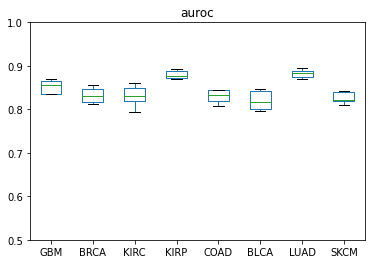

In [3]:
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
fig,ax=plt.subplots()
df_auroc.boxplot(ax=ax)
ax.set_title("auroc")
ax.set_xticks(ax.get_xticks(),rotation=90)
ax.grid(False)
ax.set_ylim(0.5,1.0)
fig.savefig(f'auroc.pdf',dpi=1200)
plt.show()

In [4]:
df = pd.DataFrame()
df_gc = pd.DataFrame()
df_reads = pd.DataFrame()

for cancer_name in  ["BLCA","BRCA","GBM","COAD","KIRC","KIRP","LUAD","SKCM"]:
    
    print(cancer_name)
    
    master_df = 0.0
    for fold_idx in range(5):
        print(fold_idx)
        preds_df = pd.read_csv(f"{outdir}/{cancer_name}/fold_{fold_idx}/peak_preds.csv")
        if type(master_df) == float:
            master_df = preds_df
        else:
            master_len_before = master_df.shape[0]
            master_df = pd.merge(master_df,preds_df)
            assert master_df.shape[0] == master_len_before
        

    master_df["model_avg"] = (master_df["preds_0"] + master_df["preds_1"] + master_df["preds_2"] + master_df["preds_3"] + master_df["preds_4"])/5
    
    
    ### load the read counts
    reads_df = pd.read_csv(f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/peakcounts_Cancer/{cancer_name}_peaksums.csv")[["seqnames","start","end","rowsum_Data"]]
    reads_df["start"] -= (1364-500)//2
    reads_df["end"] = reads_df["start"] + 1364
    master_df_reads = master_df.merge(reads_df,how="left")
    assert master_df_reads.shape[0] == master_df.shape[0]
    assert not len(master_df_reads[master_df_reads["rowsum_Data"].isna()])
    master_df_reads["counts"] = master_df_reads["rowsum_Data"].astype(int)

    ### compute gc
    

    inside = 250
    outside = 1364

    ltq2_df = master_df_reads
    

    outside_500 = (ltq2_df[f"gc_{outside}"] * outside - ltq2_df[f"gc_{inside}"] * inside ) / (outside-inside)
    inside_500 = ltq2_df[f"gc_{inside}"]
    total = ltq2_df[f"gc_{outside}"]

    spr, pval = scipy.stats.spearmanr(outside_500, ltq2_df["model_avg"])
    df.loc[cancer_name,f"between {inside} - {outside}"] = spr
    spr, pval = scipy.stats.spearmanr(inside_500, ltq2_df["model_avg"])
    df.loc[cancer_name,f"inside {inside}"] = spr
    spr, pval = scipy.stats.spearmanr(total, ltq2_df["model_avg"])
    df.loc[cancer_name,f"inside {outside}"] = spr
    counts = len(outside_500),len(inside_500)
    
    
    spr, pval = scipy.stats.spearmanr(ltq2_df["counts"], ltq2_df["model_avg"])
    df.loc[cancer_name, "read"] = spr
    
    for fold_num in range(5):
        spr, pval = scipy.stats.spearmanr(master_df_reads[f"preds_{fold_num}"], master_df_reads["gc_1364"])
        df_gc.loc[fold_num,cancer_name] = spr
        spr, pval = scipy.stats.spearmanr(master_df_reads[f"preds_{fold_num}"], master_df_reads["counts"])
        df_reads.loc[fold_num,cancer_name] = spr
        

df



BLCA
0
1
2
3
4
BRCA
0
1
2
3
4
GBM
0
1
2
3
4
COAD
0
1
2
3
4
KIRC
0
1
2
3
4
KIRP
0
1
2
3
4
LUAD
0
1
2
3
4
SKCM
0
1
2
3
4


,between 250 - 1364,inside 250,inside 1364,read
BLCA,-0.027716,-0.110252,-0.045413,0.068051
BRCA,0.042715,-0.044107,0.026971,0.049039
GBM,-0.140163,-0.103543,-0.137814,0.051883
COAD,-0.018255,-0.069413,-0.028511,0.058049
KIRC,0.090161,0.073791,0.091389,0.046778
KIRP,-0.075609,-0.075133,-0.078421,0.038716
LUAD,-0.096378,-0.142150,-0.108886,0.044873
SKCM,-0.004752,-0.009930,-0.007670,0.062940


In [5]:
df

,between 250 - 1364,inside 250,inside 1364,read
BLCA,-0.027716,-0.110252,-0.045413,0.068051
BRCA,0.042715,-0.044107,0.026971,0.049039
GBM,-0.140163,-0.103543,-0.137814,0.051883
COAD,-0.018255,-0.069413,-0.028511,0.058049
KIRC,0.090161,0.073791,0.091389,0.046778
KIRP,-0.075609,-0.075133,-0.078421,0.038716
LUAD,-0.096378,-0.142150,-0.108886,0.044873
SKCM,-0.004752,-0.009930,-0.007670,0.062940


In [7]:
df_reads.loc[5,:] = df["read"]
df_gc.loc[5,:] = df["inside 1364"]

In [8]:
display(df_reads)
df_reads.to_excel("reads_correlation_cancer.xlsx",index=None)

,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD,SKCM
0,0.064921,0.039631,0.054951,0.047902,0.048744,0.030221,0.042840,0.059237
1,0.060319,0.041690,0.047220,0.057196,0.060396,0.039132,0.037199,0.051829
2,0.060487,0.048213,0.053968,0.064566,0.036361,0.038742,0.028672,0.063509
3,0.051951,0.045119,0.062826,0.040242,0.025282,0.029868,0.051792,0.061306
4,0.064544,0.052450,0.019082,0.046144,0.040213,0.039464,0.046748,0.061727
5,0.068051,0.049039,0.051883,0.058049,0.046778,0.038716,0.044873,0.062940


In [9]:
display(df_gc)
df_gc.to_excel("gc_correlation_cancer.xlsx",index=None)

,BLCA,BRCA,GBM,COAD,KIRC,KIRP,LUAD,SKCM
0,0.065567,-0.083667,0.037123,-0.130640,0.157663,-0.161253,-0.051183,-0.069433
1,0.021305,-0.097233,-0.181635,0.183586,0.488008,-0.036835,-0.134420,-0.157251
2,0.025673,0.089572,-0.055287,0.309679,-0.005836,-0.006753,-0.324668,0.138918
3,-0.184304,0.097756,0.218187,-0.200658,-0.181740,-0.167981,0.171500,0.101297
4,0.012528,0.404661,-0.385075,-0.133730,0.119931,0.007295,-0.046272,0.162580
5,-0.045413,0.026971,-0.137814,-0.028511,0.091389,-0.078421,-0.108886,-0.007670


In [ ]:
# ### box plots
# import matplotlib
# plt.rcParams["figure.figsize"]=20,10
# matplotlib.rcParams['pdf.fonttype']=42
# fig,ax=plt.subplots()
# df_gc.boxplot(ax=ax)
# ax.set_title("GC content correlation fold-wise")
# ax.set_xticks(ax.get_xticks(),rotation=90)
# ax.grid(False)
# ax.set_ylim(-1,1)
# fig.savefig(f'gc_boxplot.pdf',dpi=1200)
# plt.show()

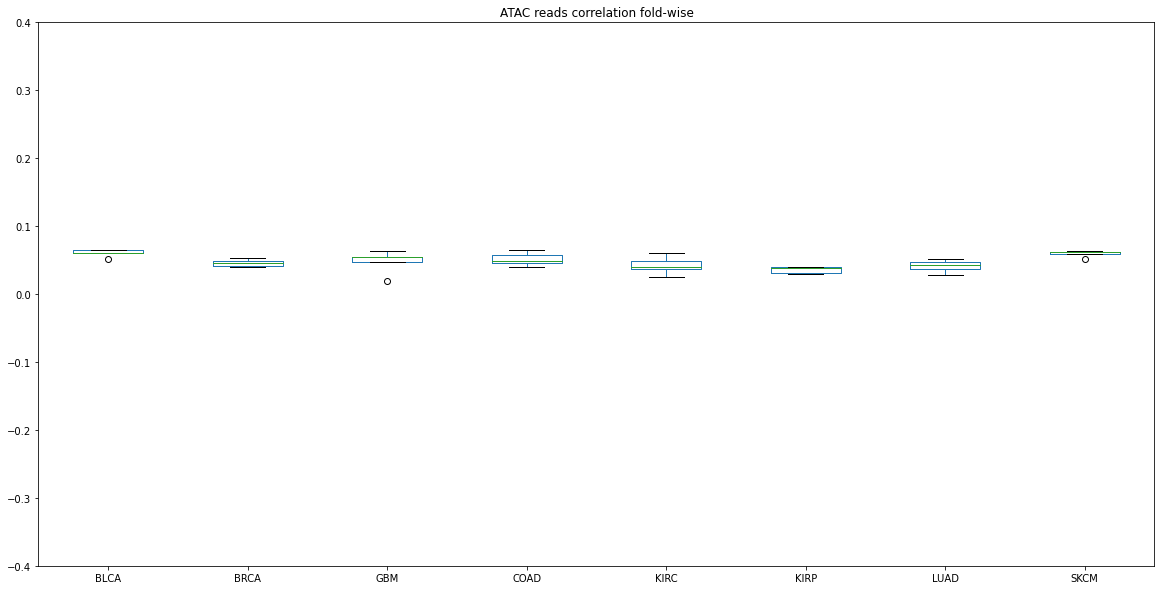

In [5]:
### box plots
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
fig,ax=plt.subplots()
df_reads.boxplot(ax=ax)
ax.set_title("ATAC reads correlation fold-wise")
ax.set_xticks(ax.get_xticks(),rotation=90)
ax.grid(False)
ax.set_ylim(-0.4,0.4)
fig.savefig(f'read_boxplot.pdf',dpi=1200)
plt.show()

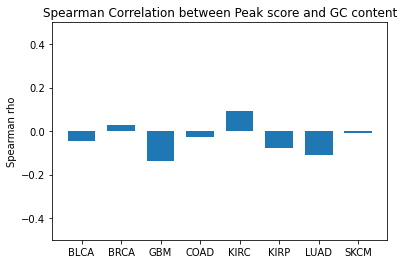

In [10]:
### bar plots
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
plt.bar(np.arange(8),
        df["inside 1364"],
        0.7,
        label=df.index,
        color='#1f77b4')
plt.ylim(-0.5,0.5)
plt.title("Spearman Correlation between Peak score and GC content")
plt.ylabel("Spearman rho")
plt.xticks(np.arange(len(df.index)), df.index)
plt.savefig(f'gc_cancer.pdf',dpi=1200)
plt.show()

In [ ]:
# ## bar plots
# import matplotlib
# plt.rcParams["figure.figsize"]=20,10
# matplotlib.rcParams['pdf.fonttype']=42
# plt.bar(np.arange(8),
#         df["read"],
#         0.7,
#         label=df.index,
#         color='#1f77b4')
# plt.ylim(-0.4,0.4)
# plt.title("Spearman Correlation between Peak score and Read count")
# plt.ylabel("Spearman rho")
# plt.xticks(np.arange(len(df.index)), df.index)
# plt.savefig(f'reads.pdf',dpi=1200)
# plt.show()

In [ ]:
#### random test unrelated to this notebook

In [12]:
df=pd.read_excel("./test_lof_publish.xlsx")

In [13]:
df

,Unnamed: 0,chr,pos,ref,alt,sample,effect_size,ref_proba,alt_proba,ref_ism,alt_ism,ism_diff,og/tsg,prioritized
0,0,chr1,978707,G,C,LUAD,-0.024571,0.623894,0.648465,0.186169,0.172975,0.013194,0,0
1,1,chr1,1552046,T,G,BRCA,-0.001262,0.567517,0.568779,-0.008160,-0.064508,0.056349,0,0
2,2,chr1,2127530,G,A,GBM,-0.049524,0.817293,0.866817,0.356885,0.435889,-0.079004,0,0
3,3,chr1,2193610,G,C,BRCA,0.004750,0.795651,0.790902,0.062991,0.018371,0.044620,0,0
4,4,chr1,2224737,C,A,BLCA,0.017585,0.390333,0.372748,0.005234,-0.774536,0.779770,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15337,15337,chr9,137396336,T,C,LUAD,0.312677,0.761473,0.448796,1.122884,-0.060694,1.183578,0,1
15338,15338,chr9,137405668,C,A,COAD,0.005860,0.813176,0.807316,-0.185964,-0.265868,0.079904,0,0
15339,15339,chr9,137436398,G,A,BLCA,-0.006511,0.936512,0.943023,-0.187652,-0.163534,-0.024118,0,0
15340,15340,chr9,137555968,A,G,COAD,0.003467,0.937267,0.933800,0.451839,0.400671,0.051168,0,0


In [14]:
l1 = len(df[(df["og/tsg"]==1) & (df["prioritized"]==1)])
l2 = len(df[(df["og/tsg"]==0) & (df["prioritized"]==1)])
l3 = len(df[(df["og/tsg"]==1) & (df["prioritized"]==0)])
l4 = len(df[(df["og/tsg"]==0) & (df["prioritized"]==0)])

In [17]:
scipy.stats.fisher_exact([[l1,l2],[l3,l4]])

(1.5142418629267003, 0.006473624241152715)